In [1]:
# ライブラリの皆さん
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.cross_validation import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import time
import seaborn as sns
from BoschUtils import sampled_data_set, general_df, use_cols_list, entire_data_set
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# 入力ファイルの皆さん

INPUT_FILES = [
#     "../output/reduced_{type}_date_normalized.csv.gz",
    "../output/{type}_categorical_L3_S32_F3854.csv.gz",
    "../output/reduced_{type}_numeric.csv.gz",
    "../output/date_diff_{type}.csv.gz",
    "../output/reduced_{type}_date.csv.gz",
    "../output/{type}_categorical_md5.csv.gz",
    "../output/{type}_date_md5.csv.gz"
]

TRAINS = []
TESTS = []

for file in INPUT_FILES:
    TRAINS.append(file.format(type="train"))
    TESTS.append(file.format(type="test"))

RESPONSE = "../output/train_response.csv.gz"

In [3]:
%%time
# 全入力データを読み込み
X = sampled_data_set(TRAINS)
y = general_df(RESPONSE).loc[X.index].values.ravel()
X = X.values

../output/train_categorical_L3_S32_F3854.csv.gz
../output/reduced_train_numeric.csv.gz
../output/date_diff_train.csv.gz
../output/reduced_train_date.csv.gz
../output/train_categorical_md5.csv.gz
../output/train_date_md5.csv.gz
CPU times: user 1min 51s, sys: 7.38 s, total: 1min 58s
Wall time: 1min 58s


In [4]:
%%time
# XGBoost の時間だめう！
clf = XGBClassifier(base_score=0.005)
clf.fit(X, y)

CPU times: user 56min 20s, sys: 2.08 s, total: 56min 23s
Wall time: 3min 58s


[   0   11   34  115  201  321  322  339  342  357  361  393  683  691  703
  705  732  736  743  752  757  819  827  829  830  832  840  844  851  852
  884  886  969  970  971  991 1094 1098 1099 1106 1107 1108 1115 1133 1134]


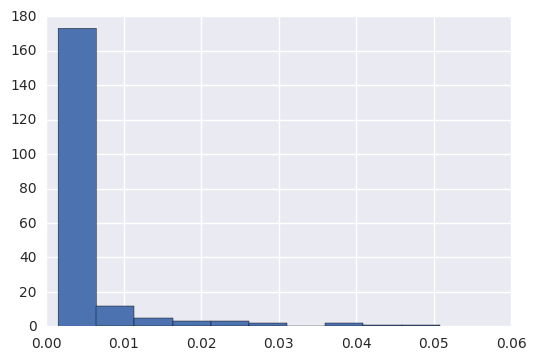

In [5]:
# とりあえず抽出
plt.hist(clf.feature_importances_[clf.feature_importances_>0])
important_indices = np.where(clf.feature_importances_ > 0.005)[0]
print(important_indices)

In [6]:
# 入力データを削減
cols_list = use_cols_list(TRAINS, important_indices)
X = entire_data_set(TRAINS, cols_list)
y = general_df(RESPONSE).values.ravel()

../output/train_categorical_L3_S32_F3854.csv.gz [0 1]
../output/reduced_train_numeric.csv.gz [  0  11  34 115 201 321 322 339 342 357 361 393 683 691 703 705 732 736
 743 752 757 819 827 829 830 832 840 844 851 852 884 886]
../output/date_diff_train.csv.gz [0 1 2 3]
../output/reduced_train_date.csv.gz [  0  20 123 127 128 135 136 137 144]
../output/train_categorical_md5.csv.gz [0 1]
../output/train_date_md5.csv.gz [0 1]


In [7]:
# 予測して Cross Validation
clf = XGBClassifier(max_depth=5, base_score=0.005)
cv = StratifiedKFold(y, n_folds=3)
predictions = np.ones(y.shape[0])
for i, (train, test) in enumerate(cv):
    predictions[test] = clf.fit(X[train], y[train]).predict_proba(X[test])[:, 1]
    print("fold {}, ROC AUC: {:.3f}".format(i, roc_auc_score(y[test], predictions[test])))
print(roc_auc_score(y, predictions))

fold 0, ROC AUC: 0.723
fold 1, ROC AUC: 0.706
fold 2, ROC AUC: 0.704
0.710212628704


0.248289208916


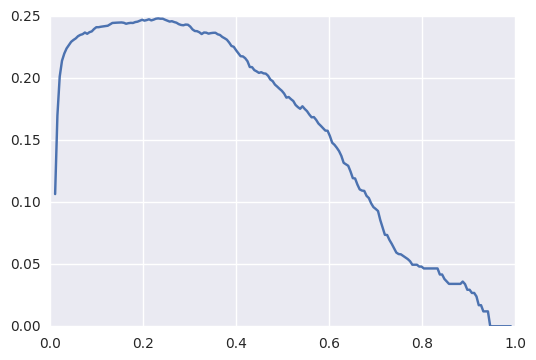

In [8]:
# MCC 最適化
thresholds = np.linspace(0.01, 0.99, 200)
mcc = np.array([matthews_corrcoef(y, predictions > thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold = thresholds[mcc.argmax()]
print(mcc.max())

In [9]:
# この時点での当たり具合を出力
tmp_threshold = best_threshold
response = pd.read_csv("../output/train_response.csv.gz", index_col=0)
response["prediction"] = predictions
predicted_one = response[response["prediction"] > tmp_threshold].groupby("Response").count()
predicted_one.rename(columns={"prediction":"Predict 1.0"}, inplace=True)
predicted_zero = response[response["prediction"] <= tmp_threshold].groupby("Response").count()
predicted_zero.rename(columns={"prediction":"Predict 0.0"}, inplace=True)
pd.concat([predicted_one, predicted_zero], axis=1)

,Predict 1.0,Predict 0.0
Response,,
0.0,1786,1175082
1.0,1123,5756


提出用データを生成する

In [10]:
# テストデータ読み込み
X = entire_data_set(TESTS, cols_list)

# 0 or 1 に正規化
predictions = (clf.predict_proba(X)[:, 1] > best_threshold).astype(np.int8)

# 提出データを生成
sub = pd.read_csv("../input/sample_submission.csv", index_col=0)
sub["Response"] = predictions
sub.to_csv("submission.csv.gz", compression="gzip")

../output/test_categorical_L3_S32_F3854.csv.gz [0 1]
../output/reduced_test_numeric.csv.gz [  0  11  34 115 201 321 322 339 342 357 361 393 683 691 703 705 732 736
 743 752 757 819 827 829 830 832 840 844 851 852 884 886]
../output/date_diff_test.csv.gz [0 1 2 3]
../output/reduced_test_date.csv.gz [  0  20 123 127 128 135 136 137 144]
../output/test_categorical_md5.csv.gz [0 1]
../output/test_date_md5.csv.gz [0 1]
